In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/My Drive/deep_learning_project/

/content/drive/.shortcut-targets-by-id/15gKjVs5Brz2wVAZdIJoqScr7ejFRXBo9/deep_learning_project


In [3]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
# from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")



import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from keras.layers.normalization import BatchNormalization
from keras import optimizers

In [27]:
X_train=np.load('/content/drive/MyDrive/deep_learning_project/X_train.npy')
X_test=np.load('/content/drive/MyDrive/deep_learning_project/X_test.npy')
y_train=np.load('/content/drive/MyDrive/deep_learning_project/y_train.npy')
y_test=np.load('/content/drive/MyDrive/deep_learning_project/y_test.npy')

In [ ]:
## Defining the input

from keras.layers import Input
xception_input = Input(shape = (224, 224, 3), name = 'Image_input')

## The RESNET model

from keras.applications.xception import preprocess_input, decode_predictions
from keras.applications.xception import Xception


#Get the RESNET weights and layers

model_xception_conv = Xception(weights= 'imagenet', include_top=False, input_shape= (224,224,3))
#model_xception_conv.summary()


83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
#Use the generated model 
from keras.models import Model


output_xception_conv = model_xception_conv(xception_input)

#Add the fully-connected layers 

x = Flatten(name='flatten')(output_xception_conv)
# x = Dense(4096, activation='relu', name='fc1')(x)
# x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)


xception_pretrained = Model( xception_input,  x)
# for layer in resnet50_pretrained.layers[:2]:
#     layer.trainable=False
# for layer in resnet50_pretrained.layers[2:]:
#     layer.trainable=True


xception_pretrained.summary()


# Compile CNN model
adam = keras.optimizers.Adam(lr=0.0001)
sgd = optimizers.SGD(lr = 0.001)
xception_pretrained.compile(loss='categorical_crossentropy',optimizer = adam,metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
predictions (Dense)          (None, 10)                1003530   
Total params: 21,865,010
Trainable params: 21,810,482
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
# import random
# index=list(range(len(y_train)))
# idx=random.sample(index,4000)
# X_train=X_train[idx]
# y_train=y_train[idx]
# X_train.shape

# learning rate 0.0001

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
import time

#Record time
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()
#Early stop
#callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)

#Learning rate schedule



#data augmentation
datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
xception_model = xception_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[time_callback],
                                                   epochs = 50, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/50
269/269 [==============================] - 220s 778ms/step - loss: 1.8516 - accuracy: 0.3239 - val_loss: 0.6948 - val_accuracy: 0.7977
Epoch 2/50
269/269 [==============================] - 208s 771ms/step - loss: 0.5178 - accuracy: 0.8191 - val_loss: 0.6763 - val_accuracy: 0.8297
Epoch 3/50
269/269 [==============================] - 208s 770ms/step - loss: 0.3679 - accuracy: 0.8743 - val_loss: 0.7482 - val_accuracy: 0.8271
Epoch 4/50
269/269 [==============================] - 208s 769ms/step - loss: 0.2991 - accuracy: 0.8956 - val_loss: 1.0727 - val_accuracy: 0.7892
Epoch 5/50
269/269 [==============================] - 208s 768ms/step - loss: 0.2565 - accuracy: 0.9132 - val_loss: 0.5795 - val_accuracy: 0.8462
Epoch 6/50
269/269 [==============================] - 208s 768ms/step - loss: 0.2266 - accuracy: 0.9219 - val_loss: 0.4901 - val_accuracy: 0.8708
Epoch 7/50
269/269 [==============================] - 208s 770ms/step - loss: 0.2062 - accuracy: 0.9297 - val_loss: 0.4503 -

In [ ]:
xception = pd.DataFrame(xception_model.history)
xception['time'] = time_callback.times
xception.to_csv('xception_adam_0001.csv')

In [ ]:
import tensorflow as tf
#Learning rate schedule
def scheduler(epoch, lr):
  if epoch < 43:
    return lr
  else:
    return lr * 0.1

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
# Fits the model on batches with real-time data augmentation:
xception_model_lr_150 = xception_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[lr_schedule,
                                                                                                                         time_callback],
                                                          epochs = 150, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/150
269/269 [==============================] - 208s 768ms/step - loss: 2.1020 - accuracy: 0.2395 - val_loss: 1.8995 - val_accuracy: 0.3547
Epoch 2/150
269/269 [==============================] - 206s 761ms/step - loss: 1.8632 - accuracy: 0.3499 - val_loss: 1.6626 - val_accuracy: 0.4378
Epoch 3/150
269/269 [==============================] - 206s 761ms/step - loss: 1.6695 - accuracy: 0.4253 - val_loss: 1.4566 - val_accuracy: 0.5141
Epoch 4/150
269/269 [==============================] - 206s 761ms/step - loss: 1.5004 - accuracy: 0.4905 - val_loss: 1.2616 - val_accuracy: 0.5907
Epoch 5/150
269/269 [==============================] - 206s 760ms/step - loss: 1.3707 - accuracy: 0.5384 - val_loss: 1.1384 - val_accuracy: 0.6171
Epoch 6/150
269/269 [==============================] - 206s 760ms/step - loss: 1.2476 - accuracy: 0.5717 - val_loss: 0.9345 - val_accuracy: 0.6988
Epoch 7/150
269/269 [==============================] - 206s 761ms/step - loss: 1.1506 - accuracy: 0.6041 - val_loss: 0

In [ ]:
xception = pd.DataFrame(xception_model_lr_150.history)
xception['time'] = time_callback.times
xception.to_csv('xception_lr_150.csv')

In [ ]:
#Record time
import time
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()
#Early stop
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)

# Fits the model on batches with real-time data augmentation:
xception_model_lr_150 = xception_pretrained.fit(x = X_train,y=y_train, callbacks=[time_callback],
                                                epochs = 50,batch_size=64, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/50
270/270 [==============================] - 211s 756ms/step - loss: 1.5393 - accuracy: 0.5494 - val_loss: 1.4497 - val_accuracy: 0.5156
Epoch 2/50
270/270 [==============================] - 202s 748ms/step - loss: 0.3654 - accuracy: 0.9365 - val_loss: 1.3516 - val_accuracy: 0.5499
Epoch 3/50
270/270 [==============================] - 202s 748ms/step - loss: 0.1950 - accuracy: 0.9687 - val_loss: 1.3177 - val_accuracy: 0.5640
Epoch 4/50
270/270 [==============================] - 201s 746ms/step - loss: 0.1283 - accuracy: 0.9808 - val_loss: 1.2846 - val_accuracy: 0.5693
Epoch 5/50
270/270 [==============================] - 202s 747ms/step - loss: 0.0924 - accuracy: 0.9880 - val_loss: 1.2861 - val_accuracy: 0.5763
Epoch 6/50
270/270 [==============================] - 202s 747ms/step - loss: 0.0733 - accuracy: 0.9909 - val_loss: 1.2815 - val_accuracy: 0.5728
Epoch 7/50
270/270 [==============================] - 202s 746ms/step - loss: 0.0598 - accuracy: 0.9930 - val_loss: 1.2567 -

In [ ]:
xception = pd.DataFrame(xception_model_lr_150.history)
xception['time'] = time_callback.times
xception.to_csv('xception_noaugmentation.csv')

# Adam no agunebtation

In [ ]:
#Record time
import time
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()
#Early stop
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)

# Fits the model on batches with real-time data augmentation:
xception_model = xception_pretrained.fit(x = X_train,y=y_train, callbacks=[time_callback],
                                         epochs = 50,batch_size=64, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/50
270/270 [==============================] - 152s 482ms/step - loss: 0.5158 - accuracy: 0.8382 - val_loss: 0.8970 - val_accuracy: 0.7008
Epoch 2/50
270/270 [==============================] - 128s 474ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 0.8282 - val_accuracy: 0.7393
Epoch 3/50
270/270 [==============================] - 128s 474ms/step - loss: 0.0018 - accuracy: 0.9999 - val_loss: 0.7642 - val_accuracy: 0.7528
Epoch 4/50
270/270 [==============================] - 128s 473ms/step - loss: 4.7134e-04 - accuracy: 0.9998 - val_loss: 0.7583 - val_accuracy: 0.7648
Epoch 5/50
270/270 [==============================] - 128s 473ms/step - loss: 8.7911e-05 - accuracy: 1.0000 - val_loss: 0.7530 - val_accuracy: 0.7678
Epoch 6/50
270/270 [==============================] - 128s 473ms/step - loss: 6.9813e-05 - accuracy: 1.0000 - val_loss: 0.7510 - val_accuracy: 0.7683
Epoch 7/50
270/270 [==============================] - 128s 473ms/step - loss: 4.3488e-05 - accuracy: 1.0000 - va

In [ ]:
xception = pd.DataFrame(xception_model.history)
xception['time'] = time_callback.times
xception.to_csv('xception_adam_0001_noaug.csv')

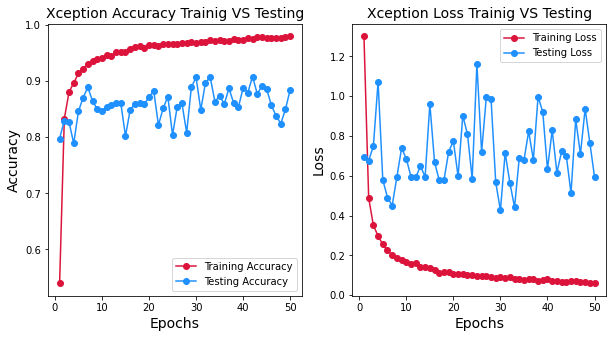

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(xception_pretrained.history.history['accuracy']) + 1), xception_pretrained.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(xception_pretrained.history.history['val_accuracy']) + 1), xception_pretrained.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('Xception Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(xception_pretrained.history.history['loss']) + 1), xception_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(xception_pretrained.history.history['val_loss']) + 1), xception_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('Xception Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
import time

#Record time
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()
#Early stop
#callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)

#Learning rate schedule



#data augmentation
datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
xception_model = xception_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[time_callback],
                                                   epochs = 10, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/10
269/269 [==============================] - 228s 772ms/step - loss: 1.8423 - accuracy: 0.3248 - val_loss: 0.4677 - val_accuracy: 0.8555
Epoch 2/10
269/269 [==============================] - 207s 764ms/step - loss: 0.5197 - accuracy: 0.8219 - val_loss: 0.4364 - val_accuracy: 0.8770
Epoch 3/10
269/269 [==============================] - 206s 763ms/step - loss: 0.3911 - accuracy: 0.8671 - val_loss: 0.6414 - val_accuracy: 0.8467
Epoch 4/10
269/269 [==============================] - 206s 763ms/step - loss: 0.3247 - accuracy: 0.8873 - val_loss: 0.4228 - val_accuracy: 0.8829
Epoch 5/10
269/269 [==============================] - 206s 763ms/step - loss: 0.2636 - accuracy: 0.9097 - val_loss: 0.5571 - val_accuracy: 0.8667
Epoch 6/10
269/269 [==============================] - 206s 763ms/step - loss: 0.2405 - accuracy: 0.9171 - val_loss: 0.4335 - val_accuracy: 0.9019
Epoch 7/10
269/269 [==============================] - 206s 763ms/step - loss: 0.2062 - accuracy: 0.9292 - val_loss: 0.4948 -

In [ ]:
xception = pd.DataFrame(xception_model.history)
xception['time'] = time_callback.times
xception.to_csv('xception_p100.csv')

In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import time

checkpointer = ModelCheckpoint('best_model.hdf5',monitor='val_accuracy', verbose=1, save_best_only=True)


#data augmentation
datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
xception_model = xception_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer],
                                                   epochs = 50, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/50
269/269 [==============================] - 212s 782ms/step - loss: 0.6395 - accuracy: 0.7824 - val_loss: 0.4821 - val_accuracy: 0.8611

Epoch 00001: val_accuracy improved from -inf to 0.86113, saving model to best_model.hdf5
Epoch 2/50
269/269 [==============================] - 209s 773ms/step - loss: 0.4121 - accuracy: 0.8588 - val_loss: 0.3572 - val_accuracy: 0.8984

Epoch 00002: val_accuracy improved from 0.86113 to 0.89841, saving model to best_model.hdf5
Epoch 3/50
269/269 [==============================] - 209s 771ms/step - loss: 0.3280 - accuracy: 0.8852 - val_loss: 0.4788 - val_accuracy: 0.8749

Epoch 00003: val_accuracy did not improve from 0.89841
Epoch 4/50
269/269 [==============================] - 208s 769ms/step - loss: 0.2850 - accuracy: 0.9027 - val_loss: 0.4883 - val_accuracy: 0.8655

Epoch 00004: val_accuracy did not improve from 0.89841
Epoch 5/50
269/269 [==============================] - 208s 768ms/step - loss: 0.2460 - accuracy: 0.9150 - val_loss: 0.424

# Example Output

In [63]:
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model
import pandas as pd

In [5]:
model = load_model('best_model.hdf5')

labels = ['safe driving'
,'texting - right'
,'talking on the phone - right'
,'texting - left'
,'talking on the phone - left'
,'operating the radio'
,'drinking'
,'reaching behind'
,'hair and makeup'
,'talking to passenger']

In [69]:
#Predict label and draw
def predict(image):
  img = cv2.imread(image)
  img = img[50:,120:-50]
  img = cv2.resize(img,(224,224))

  Pred = model.predict(np.array([img]))

  plt.imshow(img[:,:,::-1])
  plt.title(labels[np.argmax(Pred)])
  plt.show()

#Predict probability for labels
def pred_prob(image):
  img = cv2.imread(image)
  img = img[50:,120:-50]
  img = cv2.resize(img,(224,224))

  Pred = model.predict(np.array([img]))
  df = pd.DataFrame({'Label':labels,'Probability':Pred.reshape(-1)})
  return df

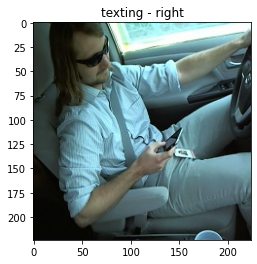

In [62]:
predict('img_99994.jpg')

In [70]:
pred_prob('img_99994.jpg')

,Label,Probability
0,safe driving,1.936884e-04
1,texting - right,9.980491e-01
2,talking on the phone - right,1.692996e-03
3,texting - left,5.744320e-07
4,talking on the phone - left,2.088757e-07
5,operating the radio,4.786846e-07
6,drinking,5.093293e-07
7,reaching behind,5.966208e-05
8,hair and makeup,1.671403e-06
9,talking to passenger,1.081695e-06


# Accuracy on each classes

In [ ]:
acu = []
for i in range(10):
  acu.append(sum(prediction[np.where(np.where(y_test == 1)[1] == i)] == i)/len(prediction[np.where(np.where(y_test == 1)[1] == i)]))

In [ ]:
import pandas as pd
text = ['safe driving'
,'texting - right'
,'talking on the phone - right'
,'texting - left'
,'talking on the phone - left'
,'operating the radio'
,'drinking'
,'reaching behind'
,'hair and makeup'
,'talking to passenger']

pd.DataFrame({'Label':text,'Accuracy':acu})

,Label,Accuracy
0,safe driving,0.832524
1,texting - right,0.935103
2,talking on the phone - right,0.979885
3,texting - left,0.994987
4,talking on the phone - left,0.929293
5,operating the radio,0.947891
6,drinking,0.880102
7,reaching behind,0.991018
8,hair and makeup,0.689759
9,talking to passenger,0.392157


In [ ]:
#Record time
import time
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()
#Early stop
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)

# Fits the model on batches with real-time data augmentation:
xception_model_lr_150 = xception_pretrained.fit(x = X_train,y=y_train, callbacks=[time_callback],
                                                epochs = 2,batch_size=64, verbose = 1, validation_data = (X_test, y_test))

In [ ]:
!nvidia-smi

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
Sun May  9 13:02:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    34W / 250W |    477MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+-------------------